In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import graphviz
from sklearn.tree import export_graphviz

# import data

In [2]:
# import the data
path = "../data/playstation.csv"
df = pd.read_csv(path)
df.head()

,ACCT_ID,SUBSCRIPTION_BILLABLE_TYPE,SUBSCRIPTION_TYPE,SKU_LENGTH,SUB_STATE,SUB_START_DATE,SUB_END_DATE
0,1.883680e+14,Paid,Wallet,1 month,Reclaim,2020-03-15,2020-04-15
1,1.883680e+14,Paid,Wallet,1 month,Renewal,2020-04-15,2020-05-15
2,1.883680e+14,Paid,Wallet,1 month,Renewal,2020-05-16,2020-06-16
3,1.883680e+14,Paid,Wallet,1 month,Renewal,2020-06-16,2020-07-16
4,1.883680e+14,Paid,Wallet,1 month,Renewal,2020-07-16,2020-08-16


# clean data

In [3]:
# change format to datetime
df["SUB_START_DATE"] = pd.to_datetime(df["SUB_START_DATE"])
df["SUB_END_DATE"] = pd.to_datetime(df["SUB_END_DATE"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28261 entries, 0 to 28260
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ACCT_ID                     28261 non-null  float64       
 1   SUBSCRIPTION_BILLABLE_TYPE  28261 non-null  object        
 2   SUBSCRIPTION_TYPE           28261 non-null  object        
 3   SKU_LENGTH                  28261 non-null  object        
 4   SUB_STATE                   28261 non-null  object        
 5   SUB_START_DATE              28261 non-null  datetime64[ns]
 6   SUB_END_DATE                28261 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.5+ MB


# reclaim vs renewal

In [4]:
df_sorted = df.sort_values(by=["ACCT_ID", "SUB_START_DATE"])
df_sorted["SUB_END_DATE_PREVIOUS"] = df_sorted["SUB_END_DATE"].shift(1)
df_sorted["ACCT_ID_PREVIOUS"] = df_sorted["ACCT_ID"].shift(1)
df_sorted["same_id"] = df_sorted["ACCT_ID_PREVIOUS"] == df_sorted["ACCT_ID"]
df_sorted["delay"] = df_sorted["SUB_END_DATE_PREVIOUS"] - df_sorted["SUB_START_DATE"]
df_sorted["delay_days"] = df_sorted["delay"].dt.days
df_sorted["sub_len"] = df_sorted["SUB_END_DATE"] - df_sorted["SUB_START_DATE"]
df_sorted["sub_len_days"] = df_sorted["sub_len"].dt.days

df_sorted_sub = df_sorted[df_sorted["SUB_STATE"].isin(["Reclaim", "Renewal"])]
df_sorted_sub = df_sorted_sub[df_sorted_sub["same_id"]]
df_sorted_sub.head()

,ACCT_ID,SUBSCRIPTION_BILLABLE_TYPE,SUBSCRIPTION_TYPE,SKU_LENGTH,SUB_STATE,SUB_START_DATE,SUB_END_DATE,SUB_END_DATE_PREVIOUS,ACCT_ID_PREVIOUS,same_id,delay,delay_days,sub_len,sub_len_days
25307,1.000400e+14,Paid,Wallet,1 month,Renewal,2020-04-25,2020-05-25,2020-04-25,1.000400e+14,True,0 days,0.0,30 days,30
12907,1.001900e+14,Paid,Wallet,12 months,Renewal,2019-07-30,2020-07-30,2019-07-27,1.001900e+14,True,-3 days,-3.0,366 days,366
12908,1.001900e+14,Paid,Wallet,12 months,Renewal,2020-07-30,2021-07-30,2020-07-30,1.001900e+14,True,0 days,0.0,365 days,365
6999,1.003400e+14,Paid,Wallet,1 month,Reclaim,2019-08-11,2019-09-11,2019-07-14,1.003400e+14,True,-28 days,-28.0,31 days,31
7000,1.003400e+14,Paid,Wallet,1 month,Reclaim,2019-11-09,2019-12-09,2019-09-11,1.003400e+14,True,-59 days,-59.0,30 days,30


In [5]:
df_sorted_sub_sub = df_sorted_sub[[
    "SUB_STATE",
    #"SUBSCRIPTION_BILLABLE_TYPE", # all equal to "paid" anyway
    "SUBSCRIPTION_TYPE",
    "delay_days",
    "SKU_LENGTH"
]]
df_sorted_sub_sub.head()

,SUB_STATE,SUBSCRIPTION_TYPE,delay_days,SKU_LENGTH
25307,Renewal,Wallet,0.0,1 month
12907,Renewal,Wallet,-3.0,12 months
12908,Renewal,Wallet,0.0,12 months
6999,Reclaim,Wallet,-28.0,1 month
7000,Reclaim,Wallet,-59.0,1 month


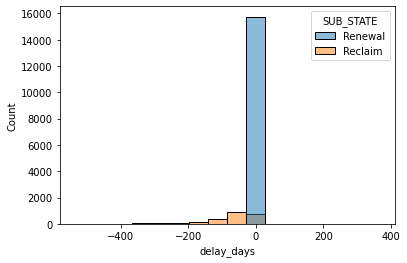

In [6]:
sns.histplot(data=df_sorted_sub_sub, x="delay_days", hue="SUB_STATE");

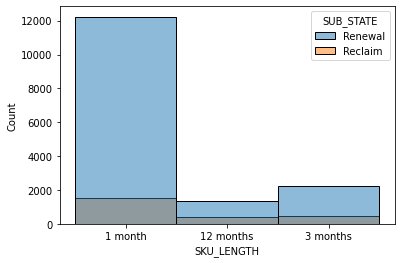

In [7]:
sns.histplot(data=df_sorted_sub_sub, x="SKU_LENGTH", hue="SUB_STATE");

## make a tree to find criteria

In [8]:
X = df_sorted_sub_sub.drop(columns="SUB_STATE")
y = df_sorted_sub_sub["SUB_STATE"]

In [9]:
y.head()

25307    Renewal
12907    Renewal
12908    Renewal
6999     Reclaim
7000     Reclaim
Name: SUB_STATE, dtype: object

In [10]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [11]:
X.head()

,SUBSCRIPTION_TYPE,delay_days,SKU_LENGTH
25307,Wallet,0.0,1 month
12907,Wallet,-3.0,12 months
12908,Wallet,0.0,12 months
6999,Wallet,-28.0,1 month
7000,Wallet,-59.0,1 month


In [12]:
X["SUBSCRIPTION_TYPE"].unique()

array(['Wallet', 'Retail'], dtype=object)

In [13]:
X["sub_type"] = X["SUBSCRIPTION_TYPE"].apply(lambda x: 0 if x == "Wallet" else 1)
X.drop(columns="SUBSCRIPTION_TYPE", inplace=True)
X.head()

,delay_days,SKU_LENGTH,sub_type
25307,0.0,1 month,0
12907,-3.0,12 months,0
12908,0.0,12 months,0
6999,-28.0,1 month,0
7000,-59.0,1 month,0


In [14]:
X["SKU_LENGTH"].unique()

array(['1 month', '12 months', '3 months'], dtype=object)

In [15]:
X["sku_len"] = X["SKU_LENGTH"].apply(lambda x: int(x.split()[0]))
X.drop(columns="SKU_LENGTH", inplace=True)
X.head()

,delay_days,sub_type,sku_len
25307,0.0,0,1
12907,-3.0,0,12
12908,0.0,0,12
6999,-28.0,0,1
7000,-59.0,0,1


In [20]:
# make tree
model = DecisionTreeClassifier(max_depth=3)
model

DecisionTreeClassifier(max_depth=3)

In [21]:
model.fit(X, y)

DecisionTreeClassifier(max_depth=3)

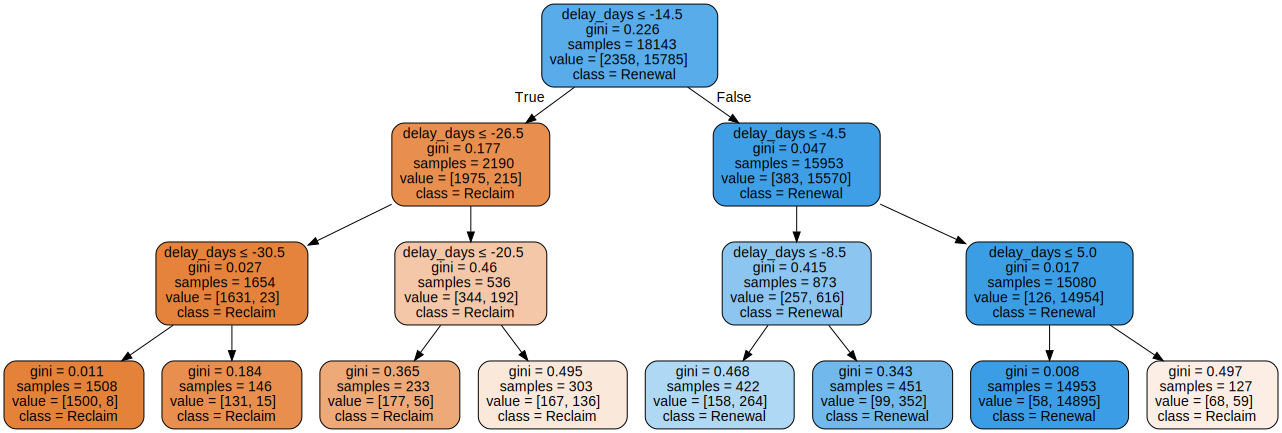

In [22]:
dot_data = export_graphviz(model, 
                  feature_names=["delay_days", "sub_type", "sku_len"],  
                  class_names=["Reclaim", "Renewal"],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

In [23]:
# This is not what I need. I needed the tree to help me find another criteria than the delay.